# Episode 40. Variational Autoencoder (VAE)

## Import Libraries

In [39]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers

## Load Data

In [40]:
# Keras gives 28x28 image data; value range 0-255; and splits train /test data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Rescale Data (value range 0-255 to range 0-1)

In [41]:
# For neural network input: scale 0-1; reshae 28x28 image to 1D (784,)
x_train = x_train.reshape(60000, 784) / 255
x_test = x_test.reshape(10000, 784) / 255

## Variational Autoencoder Network

### (1) Define Network Parameters

In [42]:
# defining the key parameters
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [43]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

### (2) Sampling Random Number

In [44]:
# sampling from mean and sd in VAE
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### (3) Defining Encoder

In [ ]:
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

### (4) Define Decoder

In [ ]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

### (5) Define Variational Autoencoder (VAE)

In [ ]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

### (6) VAE Loss

In [48]:
# Defina VAE Loss Function
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

### (7) Compile VAE

In [ ]:
vae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
vae.summary()

### (8) Train VAE

In [ ]:
history = vae.fit(x_train, x_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    verbose=1).history

Epoch 1/50
600/600 [==============================] - 5s 8ms/step - loss: 0.0616 - accuracy: 0.0130 - val_loss: 0.0518 - val_accuracy: 0.0121
Epoch 2/50
600/600 [==============================] - 5s 8ms/step - loss: 0.0501 - accuracy: 0.0096 - val_loss: 0.0484 - val_accuracy: 0.0110
Epoch 3/50
600/600 [==============================] - 5s 8ms/step - loss: 0.0475 - accuracy: 0.0092 - val_loss: 0.0467 - val_accuracy: 0.0095
Epoch 4/50
600/600 [==============================] - 5s 8ms/step - loss: 0.0461 - accuracy: 0.0097 - val_loss: 0.0455 - val_accuracy: 0.0110
Epoch 5/50
600/600 [==============================] - 5s 8ms/step - loss: 0.0450 - accuracy: 0.0096 - val_loss: 0.0446 - val_accuracy: 0.0074
Epoch 6/50
600/600 [==============================] - 5s 9ms/step - loss: 0.0443 - accuracy: 0.0082 - val_loss: 0.0442 - val_accuracy: 0.0114
Epoch 7/50
600/600 [==============================] - 5s 8ms/step - loss: 0.0436 - accuracy: 0.0088 - val_loss: 0.0434 - val_accuracy: 0.0064
Epoch 

## Encoder Output: 2D Latent Space

In [ ]:
encoder_out = encoder.predict(x_test)[2]  # encoder output is [z_mean,z_log_var,z]

In [ ]:
encoder_out.shape
encoder_out[0:5,:]

array([[-29.013298 , -97.10316  ],
       [ -3.972075 ,   2.6575434],
       [-31.912098 ,  -1.6528543],
       [  6.2889175,  -1.459423 ],
       [ -5.0304914, -77.73461  ]], dtype=float32)

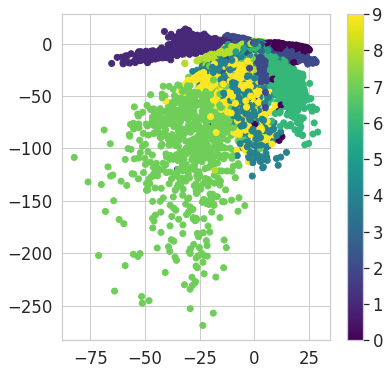

In [ ]:
# display a 2D plot of the digit classes in the latent space
plt.figure(figsize=(6, 6))
plt.scatter(encoder_out[:,0], encoder_out[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

## Reconstruction: test data

In [ ]:
vae_out = vae.predict(x_test)        # reconstruction

## Reconstruction Error: test data

In [ ]:
err2 = np.sum((x_test-vae_out)**2)/vae_out.shape[0]/vae_out.shape[1]
print('VAE reconstruction error: ' + str(round(err2,3)));

VAE reconstruction error: 0.039


## Plot Original (x) & Reconstructed (xhat) Image

In [ ]:
# select image
idx = 0
x_plot = x_test[idx,:]
xhat_plot = vae_out[idx,:]
# corresponding label
y_plot = y_test[idx]
# restore original value (from standardized 0-1 to original value 0-255)
x_plot = x_plot*255
xhat_plot = xhat_plot*255
# check label & x dimension
print(y_plot,x_plot.shape)

7 (784,)


In [ ]:
# reshape into 2D image data (784 to 28 x 28)
x_img = x_plot.reshape((28,28))
xhat_img = xhat_plot.reshape((28,28))

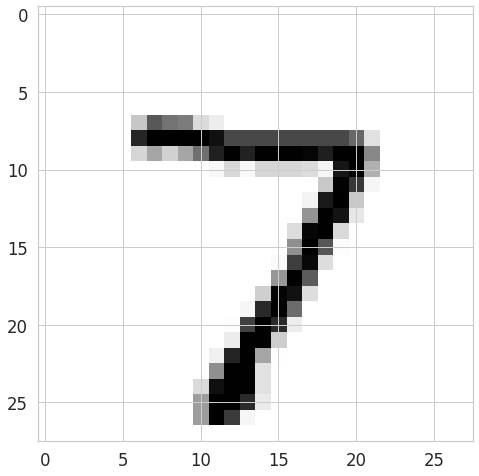

In [ ]:
# plot 2D image: Original
plt.imshow(x_img,cmap='Greys',interpolation='None')

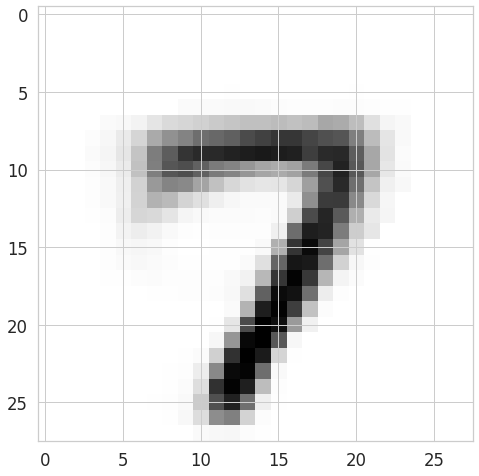

In [ ]:
# plot 2D image: Reconstructed
plt.imshow(xhat_img,cmap='Greys',interpolation='None')